In [90]:
from __future__ import print_function
import pandas as pd
import numpy as np
import datetime
import matplotlib.dates as mdates
import seaborn as sns; sns.set()
sns.set_context("poster",font_scale=1.2,rc={"font":"helvetica"});
sns.set_style("white"); #sns.set_style("ticks")
cp = sns.color_palette("colorblind") #sns.palplot(current_palette)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
import sys
sys.path.append("../src/")

import getpass
# Remove gks paths (not needed for anyone else)
if getpass.getuser()=="gks":
    try:
        sys.path.remove("/Users/gks/Dropbox/mypylib/notebooks/GIT/transitMCMC/src")
        sys.path.remove("/Users/gks/Dropbox/mypylib")
    except Exception as e:
        print(e)
        print("Paths already removed")

list.remove(x): x not in list
Paths already removed


In [91]:
from priors import PriorSet, UP, NP, JP
import tf
import pyde
import mcmc_utils
from exotk.utils.likelihood import ll_normal_ev_py, ll_normal_es, ll_normal_ev
import batman
import math
import epicblsmulti
import k2help
import utils
utils.norm_mean

<function utils.<lambda>>

# Read in data

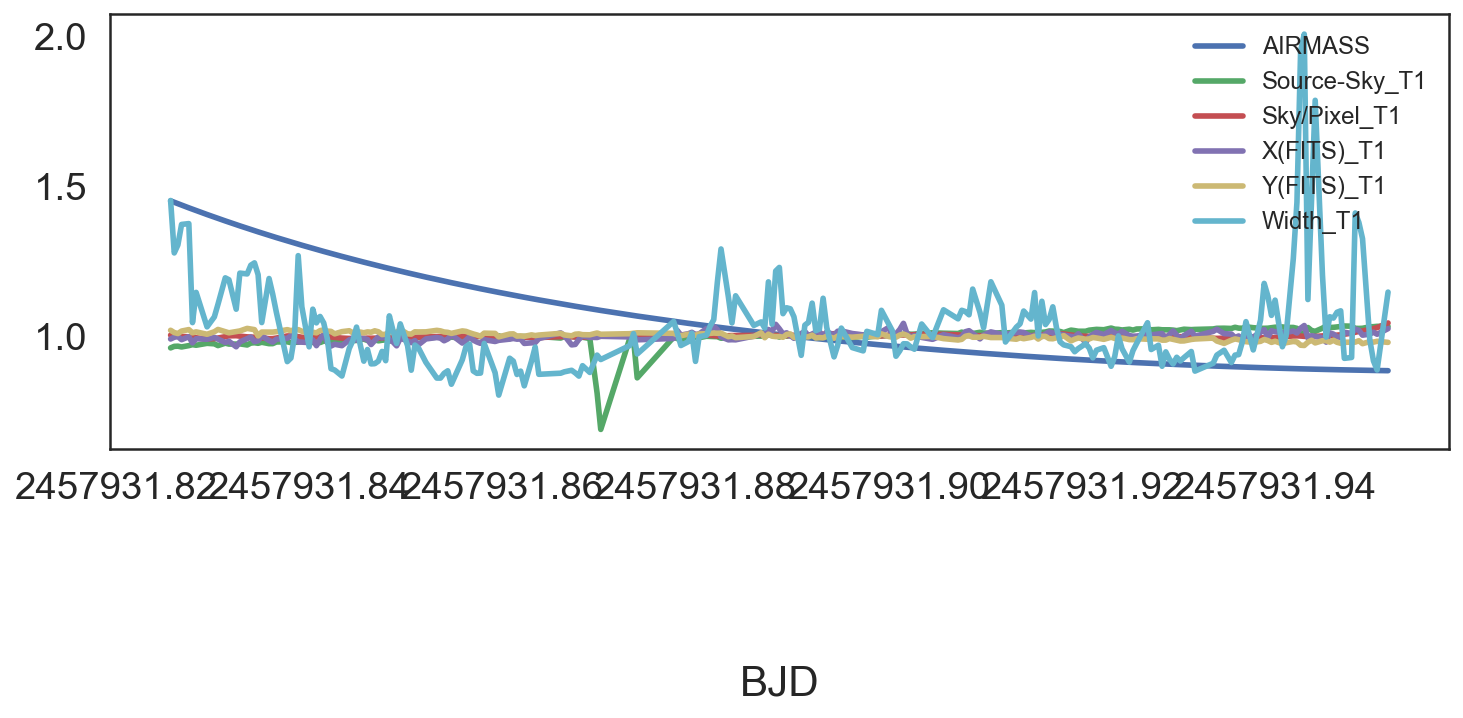

In [93]:
df_ground = pd.read_csv("../data/k2_28b/Processed_K2-28b_final_measurements.xls",sep="\t")
# Take out bad sky points
#df_ground = df_ground[0:-20]
#df_ground = df_ground[(df_ground.BJD_TDB < 2457931.888) ^ (df_ground.BJD_TDB > 2457931.892)]

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df_ground.BJD_TDB,utils.norm_median(df_ground.AIRMASS))
ax.plot(df_ground.BJD_TDB,utils.norm_median(df_ground["Source-Sky_T1"]))
ax.plot(df_ground.BJD_TDB,((utils.norm_median(df_ground["Sky/Pixel_T1"])-1)*0.1)+1.)
ax.plot(df_ground.BJD_TDB,((utils.norm_median(df_ground["X(FITS)_T1"])-1)*10.)+1.)
ax.plot(df_ground.BJD_TDB,((utils.norm_median(df_ground["Y(FITS)_T1"])-1)*10.)+1.)
ax.plot(df_ground.BJD_TDB,((utils.norm_median(df_ground["Width_T1"])-1)*10.)+1.)

ax.set_xlabel("BJD")
ax.legend(loc="upper right",fontsize=12)
ax.minorticks_on()

# Calculate scintillation errorbars

In [94]:
# Define variables
t_ground = df_ground.BJD_TDB.values
f_ground = df_ground.rel_flux_T1.values/np.nanmedian(df_ground.rel_flux_T1.values)
err_ground = df_ground.rel_flux_err_T1.values/np.nanmedian(df_ground.rel_flux_T1.values)

# Other params
NREFSTARS = 3.
cadence = np.median(np.diff(t_ground))*24.*60.*60.
print("Cadence {}s".format(cadence))

# Calculate the mean values for scintillation and photon to plot on the plot
final_unbinned_scint_noise = utils.scintillation_noise(350.,np.mean(df_ground["AIRMASS"]),cadence,2700.,withextra=True)*np.sqrt(1.+1./NREFSTARS)
final_unbinned_phot_noise = np.mean(df_ground.rel_flux_err_T1)
print("Mean photon error: {}".format(final_unbinned_phot_noise))
print("Mean scint error: {}".format(final_unbinned_scint_noise))

# Calculate full array of errors including scintilation
scint_error = utils.scintillation_noise(350.,df_ground.AIRMASS.values,cadence,2700.,withextra=True)*np.sqrt(1.+1./NREFSTARS)
tot_error = np.sqrt(scint_error**2.+err_ground**2.)

Cadence 32.5728267431s
Mean photon error: 0.000451952380952
Mean scint error: 0.000619102949387


### Plotting with scintillation errorbars

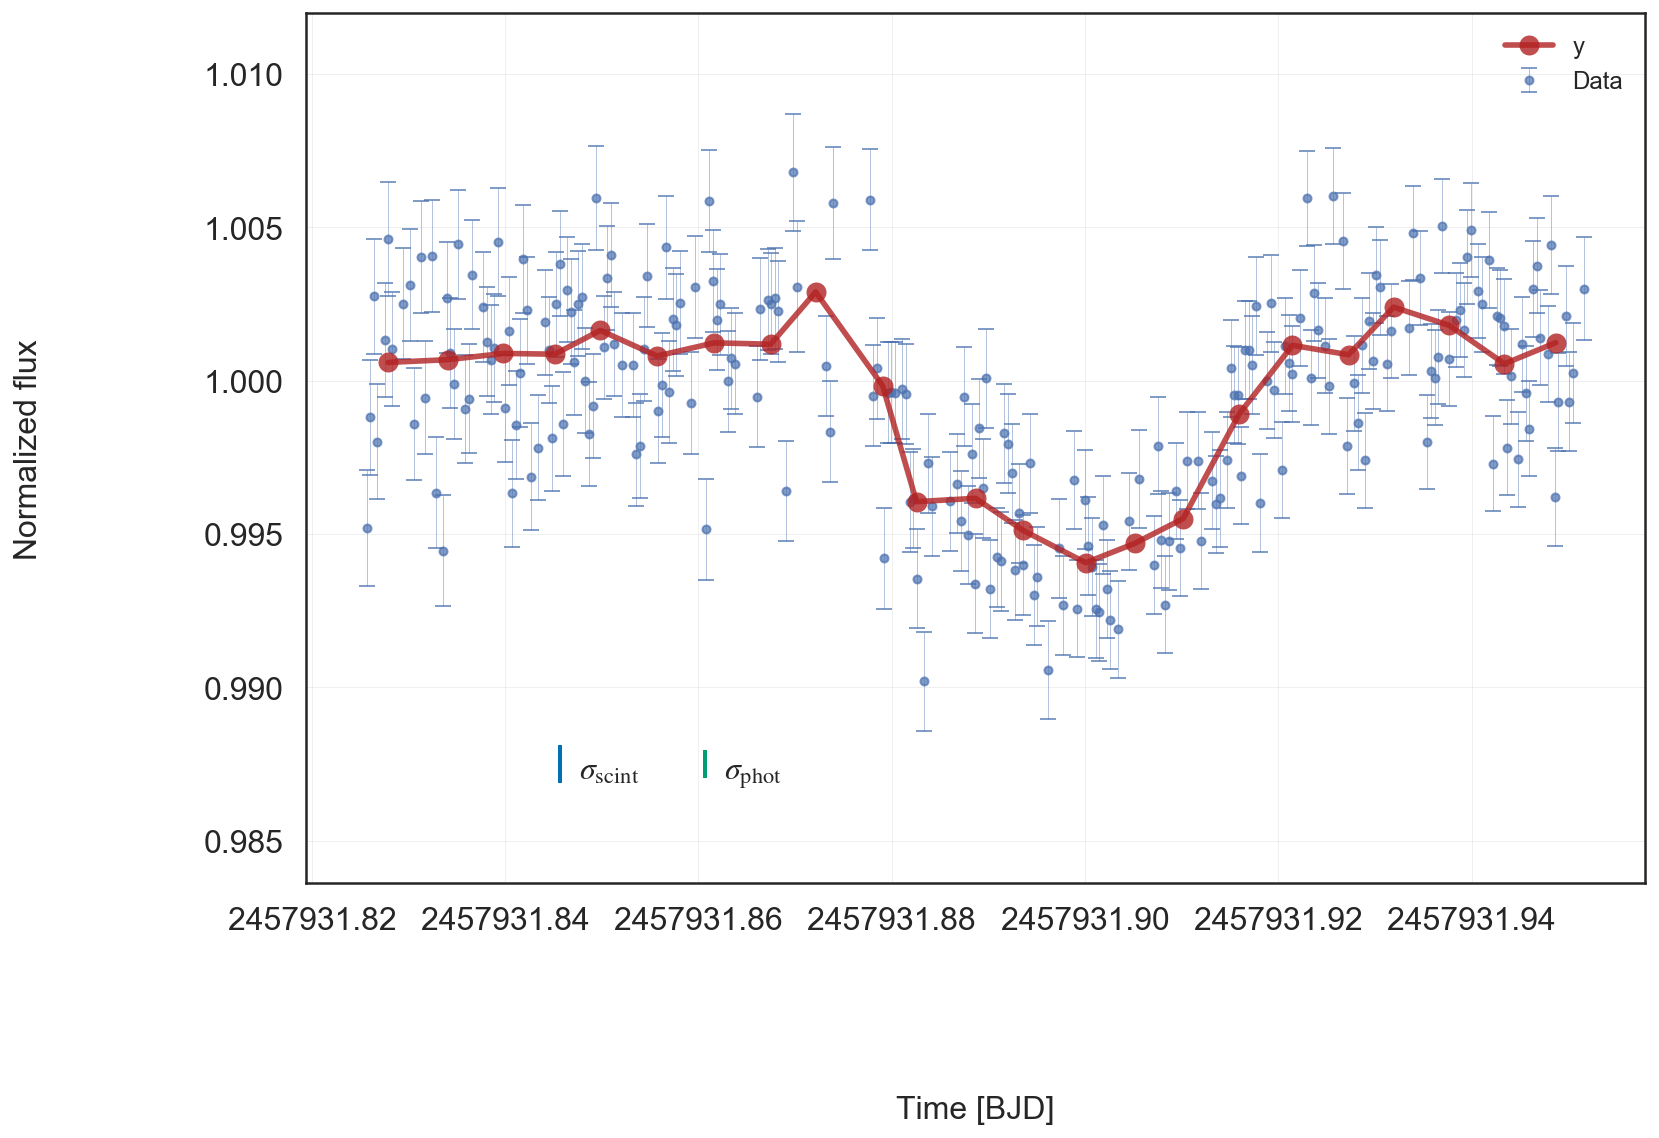

In [95]:
import plot_transits
fig, ax = plt.subplots(figsize=(12,8))
plot_transits.plot_transit_with_model(t_ground,f_ground,tot_error,ax=ax)
x0 = t_ground[0]
ax.errorbar(x0+0.01+0.01,0.9975-0.01,yerr=final_unbinned_scint_noise,elinewidth=2,color=cp[0],mew=0.5)
ax.errorbar(x0+0.025+0.01,0.9975-0.01,yerr=final_unbinned_phot_noise,elinewidth=2,color=cp[1],mew=0.5)
ax.text(x0+0.01+0.01+0.002,0.99741-0.0104,r"$\sigma_{\mathrm{scint}}$",fontsize=16)
ax.text(x0+0.025+0.01+0.002,0.99741-0.0104,r"$\sigma_{\mathrm{phot}}$",fontsize=16)

df_bin = utils.bin_data(t_ground,f_ground,10)
ax.plot(df_bin.x,df_bin.y,marker="o",markersize=10,color="firebrick",alpha=0.8)

ax.set_xlabel("Time [BJD]",fontsize=16)
ax.set_ylabel("Normalized flux",fontsize=16)
ax.minorticks_on()
ax.legend(loc="upper right",fontsize=12)
ax.margins(x=0.05,y=0.15)
ax.grid(lw=0.5,alpha=0.3)

ax.tick_params(axis="both",labelsize=16)

In [96]:
import utils
import astropylib.mcFunc

In [103]:
class LPFunction(object):
    """
    Log-Likelihood function class
    
    General philosophy:
    — Modify this for each fit
    — Outputs will be passed to emcee.sampler()
    — Outside of this are functions to plot the MCMC chains and corner plots
       
    NOTES:
    Based on hpprvi's awesome class, see: https://github.com/hpparvi/exo_tutorials
    
    I extended the Prior and Priorset classes in 
    /Users/gks/.local/lib/python2.7/site-packages/exotk
    """
    def __init__(self):
        """
        Note: number_pv_baseline must be set to whatever the index of the 'fraw' parameter is
        """
        # This is only performed during initialization
        self.data= {"time"   : t_ground,  # phase folded time in days (centered on 0)
                    "flux"   : f_ground,   # phase folded flux
                    "error"  : tot_error}
        #####
        # Setting priors
        self.priors = [#UP( _t0 -0.1           , _t0+0.1               , 'tc'       ,r'$T_C$'                 ,priortype="model"),  ##   0 - Transit centre, Tc
                       UP( 2457931.90-0.02     , 2457931.90+0.02        , 'tc'       ,r'$T_C$'                 ,priortype="model"),  ##   0 - Transit centre, Tc
                       NP( np.log10(2.260438)  , 0.00002                , 'logP'     ,r'$\log(P)$'             ,priortype="model"),  ##   1 - log(P)
                       UP( 0.                  , 0.2                    , 'cos(i)'   ,r'$\cos(i)$'             ,priortype="model"),  ##   2 - cos(i)
                       UP( 0.0                 , 0.1                    , 'RpRs'     ,r'$R_p/R_s$'             ,priortype="model"),  ##   3 - rp/rstar
                       UP( 0.9                 , 2.0                    , 'log(a/Rs)',r'$\log(a/R_s)$'         ,priortype="model"),  ##   4 - log(a/rstar)     
                       #UP( 0.                  , 1.                     , 'q1'       ,r'$q_1$'                 ,priortype="model"),  ##   5 - q1
                       #UP( 0.                  , 1.                     , 'q2'       ,r'$q_2$'                 ,priortype="model"),  ##   6 - q2
                       UP( 0.9                 , 1.1                    , 'fraw'     ,r'fraw'                  ,priortype="baseline")]  ##   7 - Baseline constant
                       #UP( 1e-5                , 50e-5                  , 'err'      ,r'error'                 ,priortype="error")]  ##   8 - Baseline constant
        
        # If we want to fix limb-dark parameters
        self.limbdark = [0.340, 0.315]#[ 0.16689202, 0.44493439] 
        self.ps     = PriorSet(self.priors)
        self.number_pv_baseline = np.where(np.array(self.ps.priortypes)=="baseline")[0][0]
        print("Baseline is at pv=",self.number_pv_baseline)
        
    def compute_transit(self,pv,times=None):
        """
        Calls BATMAN and returns the transit model
        
        INPUT:
        pv    - parameters passed to the function 
        times - times, and array of timestamps 
        
        OUTPUT:
        lc - the lightcurve model at *times*
        """
        self.params = batman.TransitParams()
        self.params.t0 = pv[0]
        self.params.per = 10.**pv[1]
        self.params.inc = np.arccos(pv[2])*180./math.pi
        self.params.rp = pv[3]
        self.params.a = 10.**pv[4]
        self.params.ecc = 0.
        self.params.w = 0.
        #q1, q2 = pv[5], pv[6]
        #self.params.u = astropylib.mcFunc.u1_u2_from_q1_q2(q1,q2) # Kipping 2013 formalism
        self.params.u = self.limbdark
        self.params.limb_dark = "quadratic"
        self.params.fp = 0.001
        if times is None:
            times = self.data["time"]        
        transitmodel = batman.TransitModel(self.params, times, transittype='primary')#supersample_factor=7,exp_time=0.020431801470066003)
        self.lc = transitmodel.light_curve(self.params)
        return self.lc        
    
    def detrend(self,pv):
        """
        A function to detrend.
        
        INPUT:
        pv    - an array containing a sample draw of the parameters defined in self.lpf.ps
        
        OUTPUT:
        detrend/pv[self.number_pv_baseline] - the additional trend in the data (no including transit)
        """
        detrend = np.zeros(len(self.data["flux"]))
        
        # loop over detrend parameters
        for i in self.ps.get_param_type_indices(paramtype="detrend"):
            #print(i)
            detrend += pv[i]*(self.data[self.ps.labels[i]]-1.)
        return detrend/pv[self.number_pv_baseline]
        
    def compute_lc_model(self,pv):
        """
        Compute the light curve model with detrend
        
        INPUT:
        pv - an array containing a sample draw of the parameters defined in self.lpf.ps
        
        OUTPUT:
        The full light curve model with a trend
        
        TODO:
        - Choose to use GPs ?
        """
        return self.compute_transit(pv) + self.detrend(pv)
    
                    
    def __call__(self,pv):
        """
        Return the log likelihood
        """
        if any(pv < self.ps.pmins) or any(pv>self.ps.pmaxs):
            return -np.inf
        # make sure that sqrtecosw is well behaved
        flux_m = self.compute_lc_model(pv)
        
        # Return the log-likelihood
        log_of_priors = self.ps.c_log_prior(pv)
        scaled_flux   = self.data["flux"]/pv[self.number_pv_baseline]
        #log_of_model  = ll_normal_es(scaled_flux, flux_m, pv[self.number_pv_error])
        log_of_model  = ll_normal_ev(scaled_flux, flux_m, self.data['error'])
        
        log_ln = log_of_priors + log_of_model
        
        return log_ln

In [104]:
# Initialize an instance of the Transit Fitter Class, using the LPFunction as defined above
TF = tf.TransitFit(LPFunction)

Baseline is at pv= 5


In [105]:
TF.minimize_PyDE(mcmc=False)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
      labels       centers         lower         upper            pv   center_dist
0         tc  2.457932e+06  2.457932e+06  2.457932e+06  2.457932e+06  2.135014e-03
1       logP  3.541926e-01  3.540926e-01  3.542926e-01  3.541927e-01 -8.746434e-08
2     cos(i)  1.000000e-01  0.000000e+00  2.000000e-01  5.208265e-02  4.791735e-02
3       RpRs  5.000000e-02  0.000000e+00  1.000000e-01  7.898140e-02 -2.898140e-02
4  log(a/Rs)  1.450000e+00  9.000000e-01  2.000000e+00  1.140829e+00  3.091708e-01
5       fraw  1.000000e+00  9.000000e-01  1.100000e+00  1.001158e+00 -1.158111e-03
LogLn value: -1056.5390831288757
Log priors 18.54585675068606


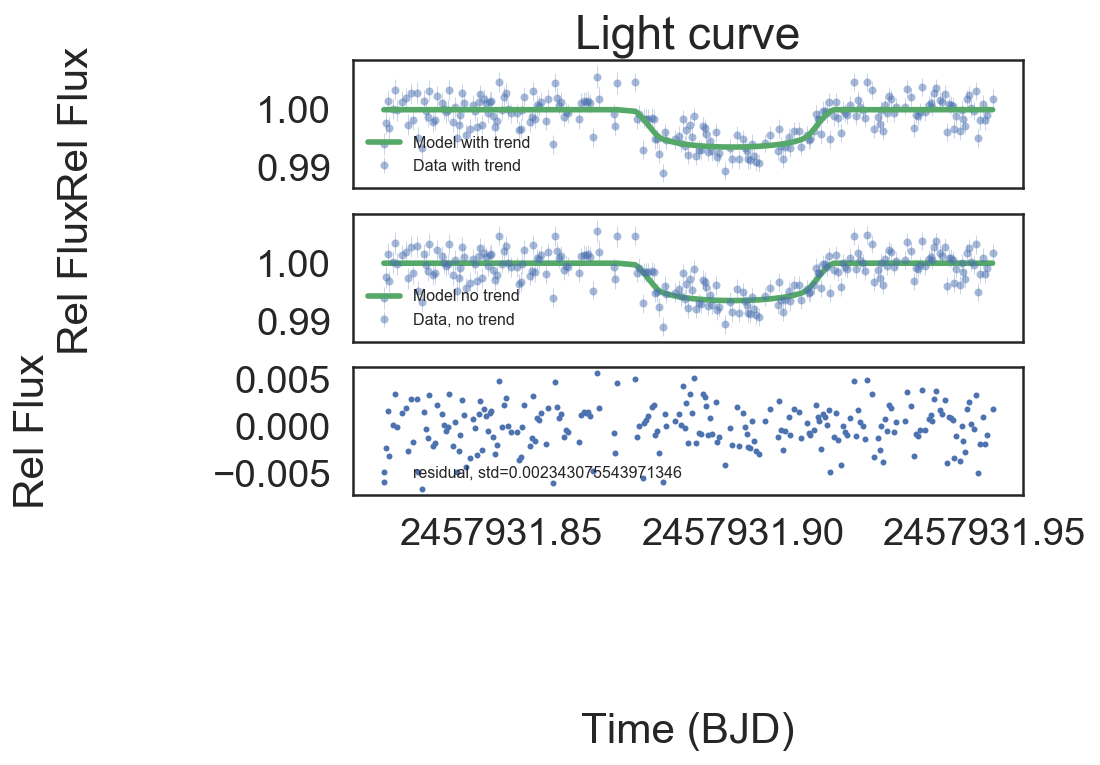

In [106]:
TF.plot_lc_fit()

In [107]:
TF.minimize_PyDE(mcmc=True,mc_iter=1000)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
      labels       centers         lower         upper            pv   center_dist
0         tc  2.457932e+06  2.457932e+06  2.457932e+06  2.457932e+06  2.131347e-03
1       logP  3.541926e-01  3.540926e-01  3.542926e-01  3.541926e-01  2.017470e-08
2     cos(i)  1.000000e-01  0.000000e+00  2.000000e-01  5.185734e-02  4.814266e-02
3       RpRs  5.000000e-02  0.000000e+00  1.000000e-01  7.888736e-02 -2.888736e-02
4  log(a/Rs)  1.450000e+00  9.000000e-01  2.000000e+00  1.141795e+00  3.082046e-01
5       fraw  1.000000e+00  9.000000e-01  1.100000e+00  1.001152e+00 -1.152363e-03
LogLn value: -1056.5384758941027
Log priors 18.5458658044271
Running MCMC
MCMC iterations= 1000
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 9

Plotting chains


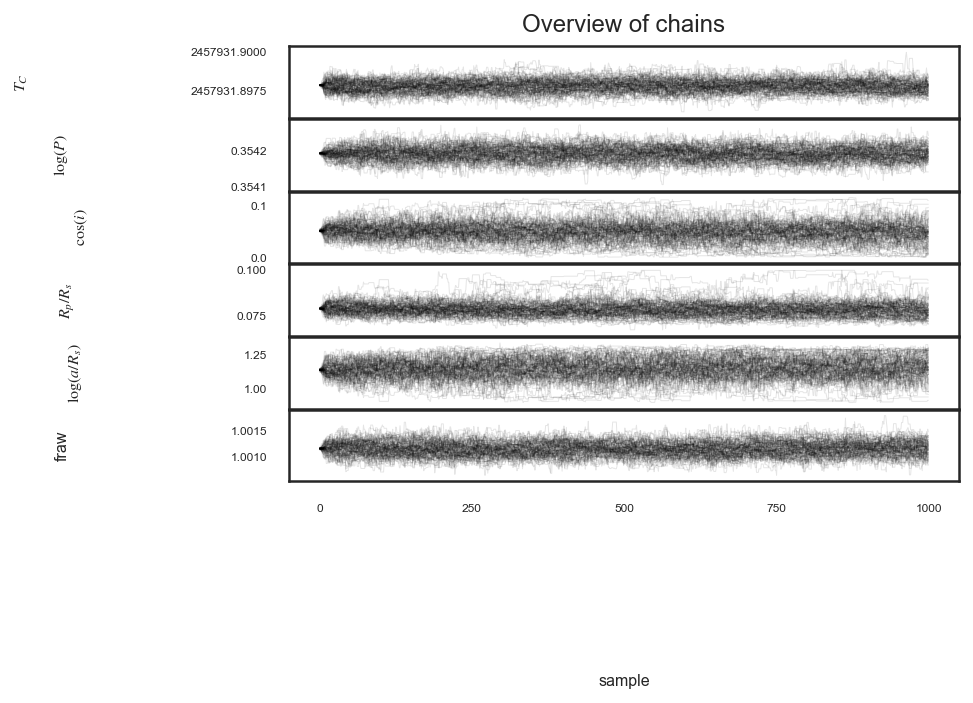

In [108]:
TF.plot_chains()

In [109]:
TF.gelman_rubin(burn=200)

array([1.06886358, 1.05246006, 1.15474121, 1.15687932, 1.13487334,
       1.04967639])

Plotting cornerplot


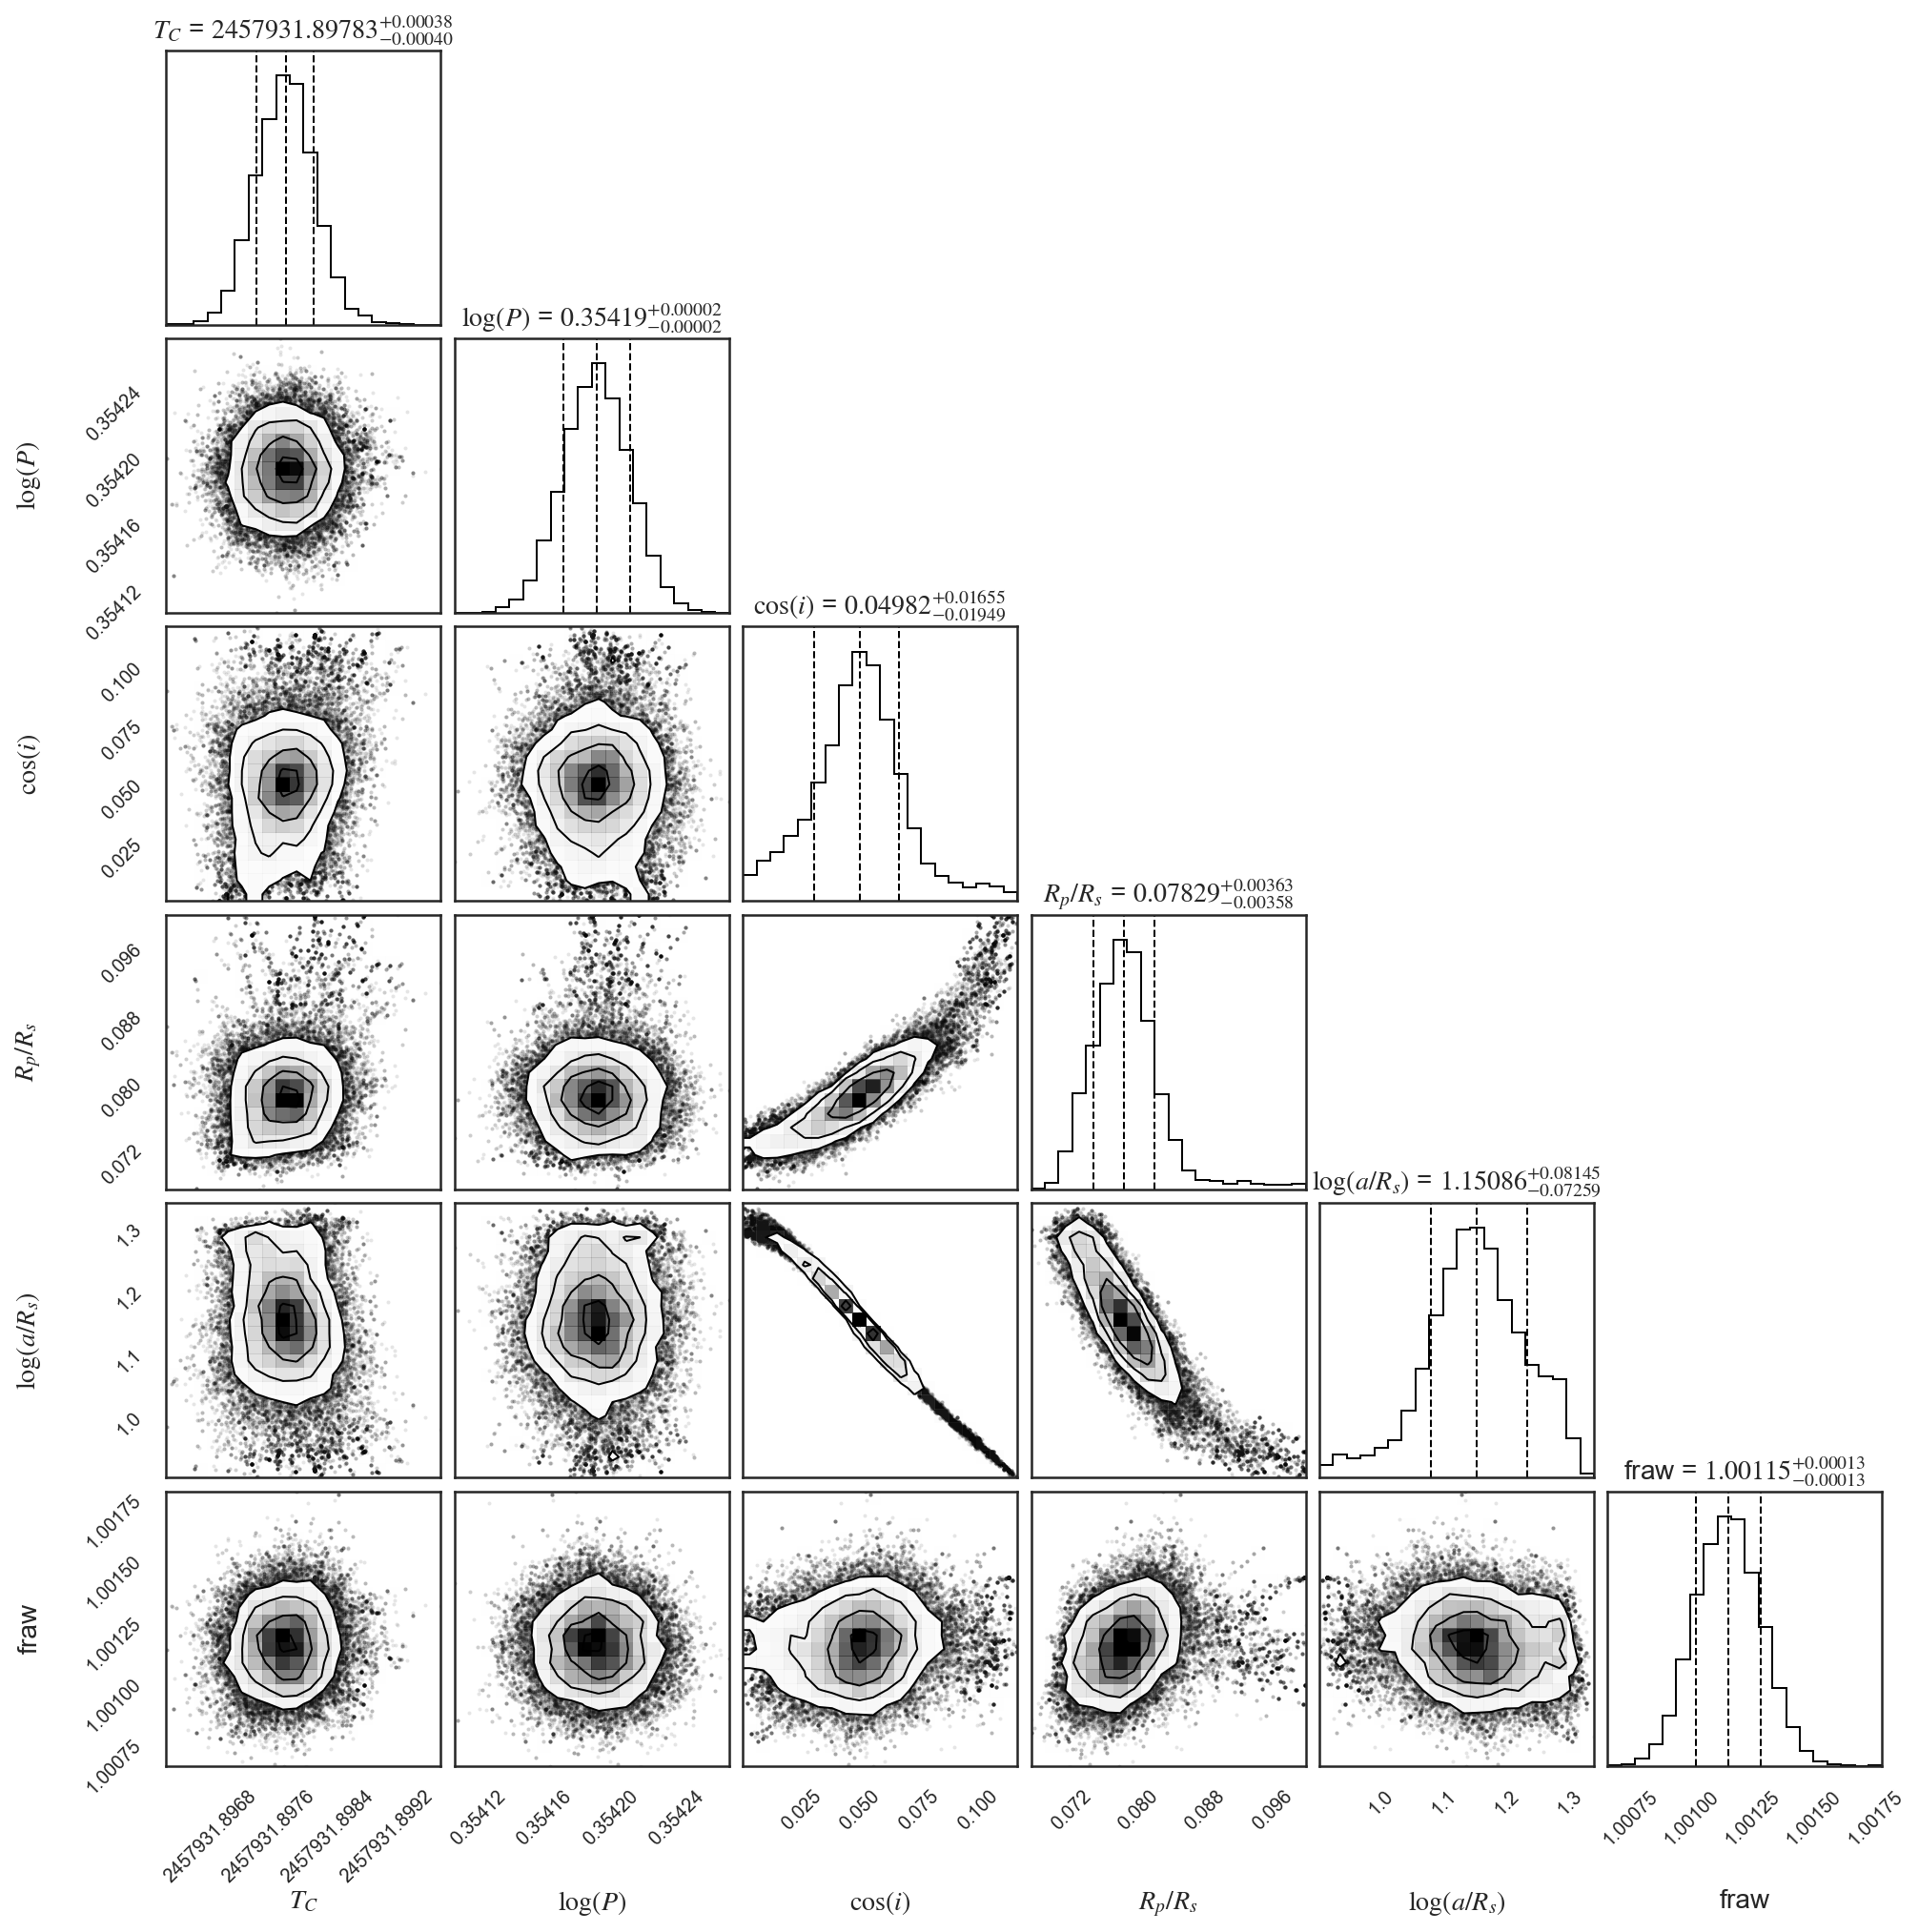

In [110]:
TF.plot_corner(show_titles=True,burn=200)

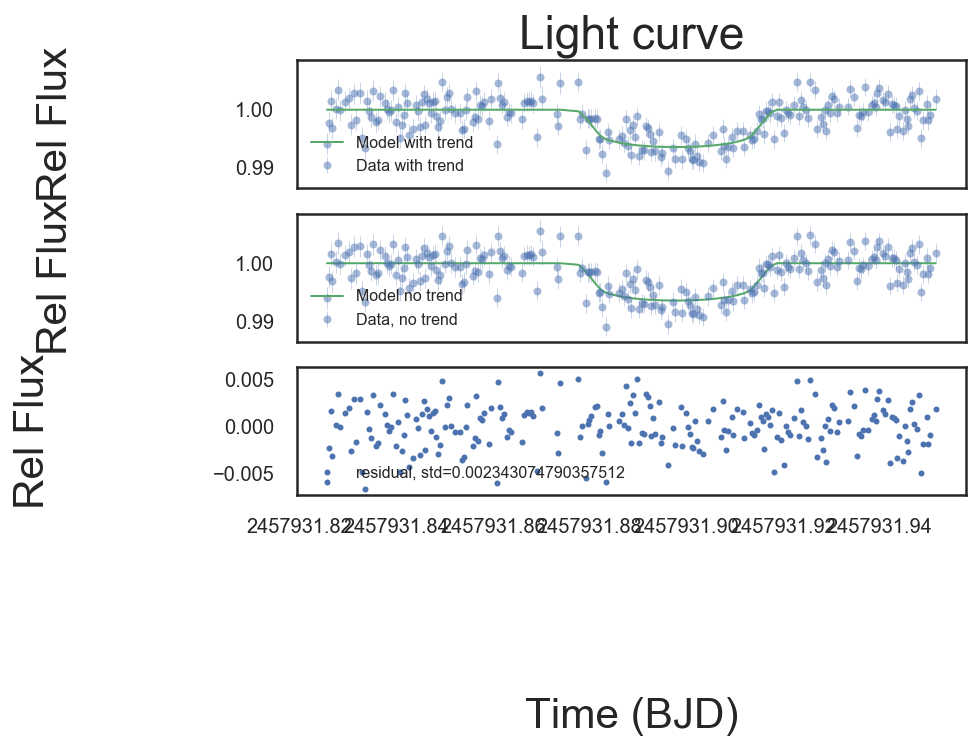

In [111]:
TF.plot_lc_fit()

In [112]:
df_param = TF.get_transit_parameters(burn=200,
                                     thin=1,
                                     st_rad=0.288,
                                     st_raderr1=0.028,
                                     st_teff=3214.,
                                     st_teff_err1=60.,
                                     rho_instead_of_aRs=False)
df_param

Assuming
R_s: 0.288 +- 0.028
Teff: 3214.0 +- 60.0
Albedo: 0.3
0.35421322873163347
2.2605453742652903
ASSUMING aRs IS JUMP PARAMETER pv[4]
18


,medvals,minus,plus,values,Labels,Description
0,2.457932e+06,0.000399,0.000383,$2457931.89783_{-0.00040}^{+0.00038}$,$T_{0}$ $(\mathrm{BJD_{TDB}})$,Transit Midpoint
1,2.260433e+00,0.000103,0.000104,$2.26043_{-0.0001}^{+0.0001}$,$P$ (days),Orbital period
2,7.829181e-02,0.003580,0.003633,$0.0783_{-0.0036}^{+0.0036}$,$R_p/R_*$,Radius ratio
3,2.460494e+00,0.260027,0.275406,$2.46_{-0.26}^{+0.28}$,$R_p (R_\oplus)$,Planet radius
4,2.195109e-01,0.023198,0.024570,$0.22_{-0.023}^{+0.025}$,$R_p (R_J)$,Planet radius
5,6.129607e-03,0.000548,0.000582,$0.00613_{-0.00055}^{+0.00058}$,$\delta$,Transit depth
6,1.415338e+01,2.178549,2.919793,$14.2_{-2.2}^{+2.9}$,$a/R_*$,Normalized orbital radius
7,1.892364e-02,0.003459,0.004289,$0.0189_{-0.0035}^{+0.0043}$,$a$ (AU),Semi-major axis
8,1.049670e+01,4.138884,7.928279,$10.5_{-4.1}^{+7.9}$,"$\rho_{\mathrm{*,transit}}$ ($\mathrm{g/cm^{3}}$)",Density of star
9,8.714429e+01,0.949715,1.117864,$87.14_{-0.95}^{+1.1}$,$i$ $(^{\circ})$,Transit inclination


In [113]:
# Calc phases
pp  = df_param["medvals"][df_param["Description"]=="Orbital period"].values[0]
tt0  = df_param["medvals"][df_param["Description"]=="Transit Midpoint"].values[0]
phases_data = utils.get_phases(TF.lpf.data["time"],pp,tt0)
phases_fit = utils.get_phases(TF.lpf.data["time"],pp,tt0)
df_fold = pd.DataFrame(zip(phases_fit,TF.model_no_trend),columns=["phase","model"]).sort_values("phase")

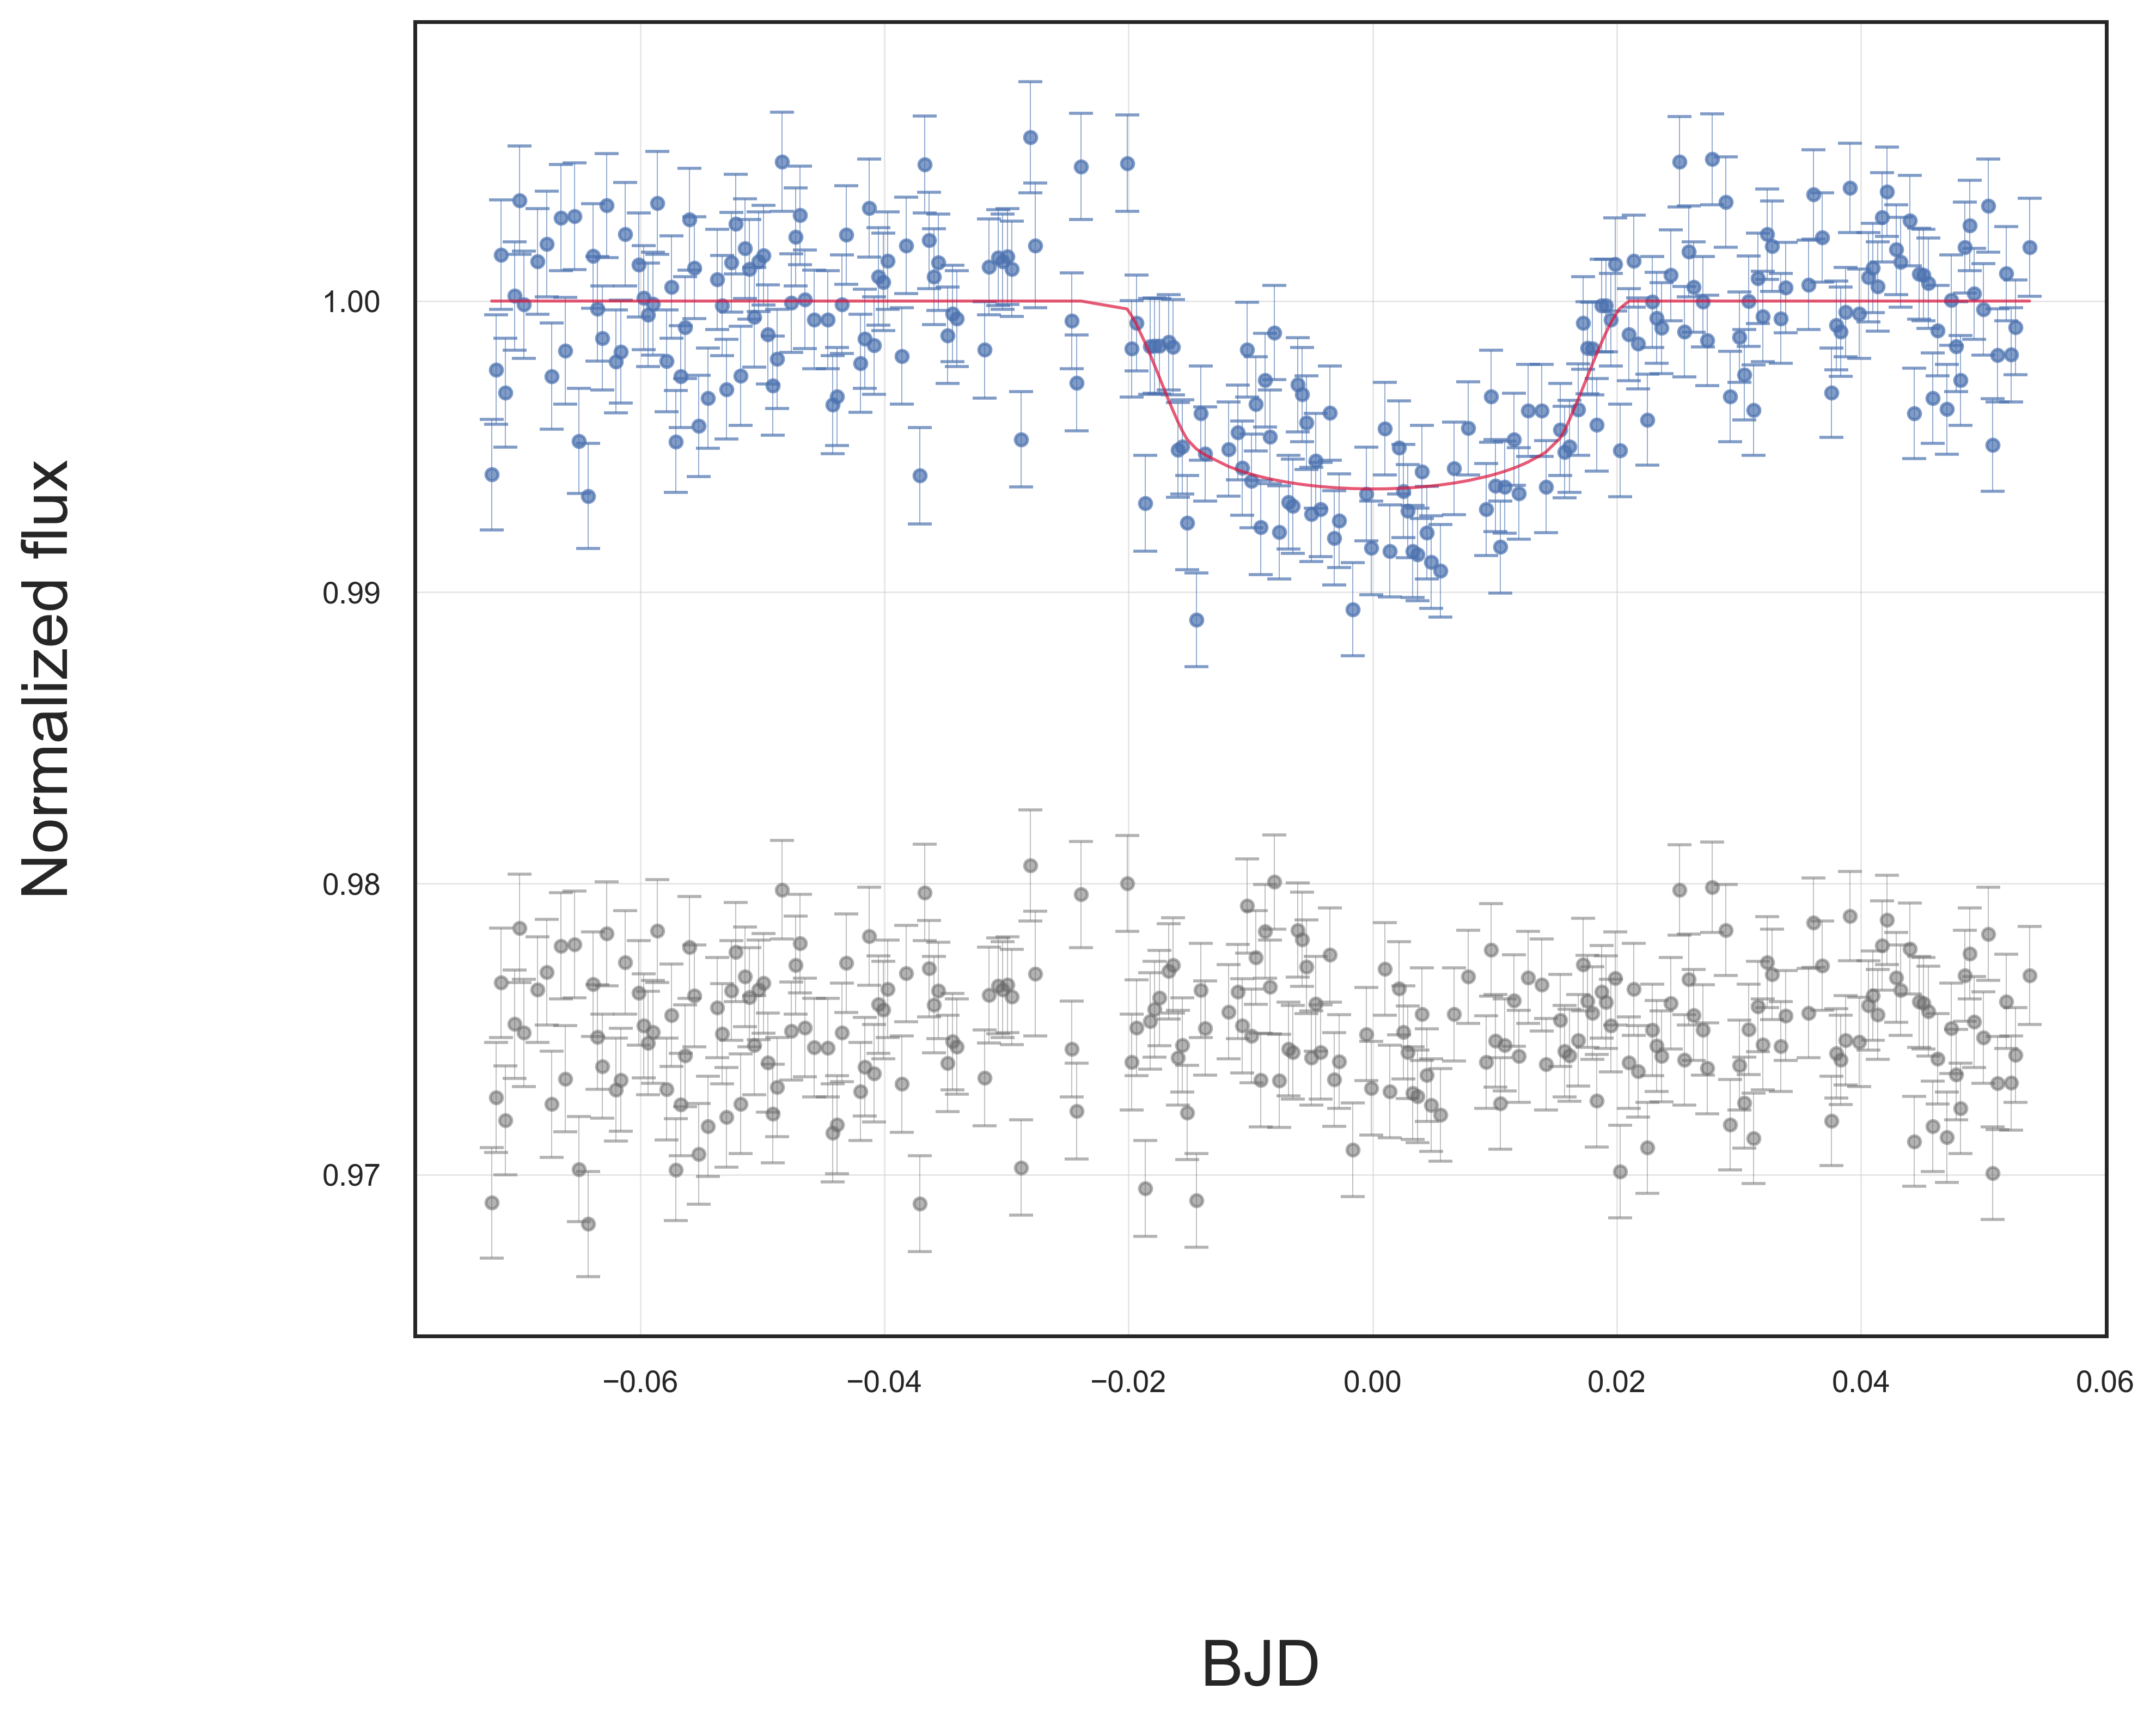

In [114]:
import plot_transits
fig, ax = plt.subplots(figsize=(10,8),dpi=200)
plot_transits.plot_transit_with_model(phases_data*pp,
                                                 TF.scaled_flux,
                                                 TF.scaled_error,
                                                 TF.residual,
                                                 df_fold.phase*pp,
                                                 df_fold.model,ax=ax,offset=0.975)
fig.tight_layout()